In [122]:
# Step 1: Loading Data and Initial Calculations

import pandas as pd
import numpy as np

# Load the dataset
data_path = '/Users/eslifolkes/OpenBBUserData/exports/20230901_154253_futures_historical.csv'
data = pd.read_csv(data_path)

# Calculate daily returns from closing prices
data['Return'] = data['Close'].pct_change().dropna()

# Display the first few rows to confirm
print(data.head())


         Date     Open     High      Low    Close  Adj Close   Volume    Return
0  2013-01-02  1443.00  1458.00  1438.25  1457.00    1457.00  1939767       NaN
1  2013-01-03  1456.00  1460.50  1450.00  1453.50    1453.50  1598235 -0.002402
2  2013-01-04  1454.00  1463.00  1451.25  1457.75    1457.75  1514786  0.002924
3  2013-01-07  1460.25  1460.75  1450.75  1455.75    1455.75  1199834 -0.001372
4  2013-01-08  1456.75  1457.00  1446.00  1452.25    1452.25  1366996 -0.002404


In [127]:
class HestonModel:
    def __init__(self, mu, kappa, theta, sigma, rho, X0, zeta0, dt):
        self.mu = mu
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho
        self.X0 = X0
        self.zeta0 = zeta0
        self.dt = dt
        
    def simulate(self, num_steps):
        # Initialize arrays to store X and zeta values
        X_values = np.zeros(num_steps)
        zeta_values = np.zeros(num_steps)
        
        X_values[0] = self.X0
        zeta_values[0] = self.zeta0

        # Generate Wiener processes
        dW1 = np.sqrt(self.dt) * np.random.randn(num_steps)
        dW2 = self.rho * dW1 + np.sqrt(1 - self.rho**2) * np.sqrt(self.dt) * np.random.randn(num_steps)

        # Euler-Maruyama method for Heston model
        for t in range(1, num_steps):
            X_values[t] = X_values[t-1] + self.mu * X_values[t-1] * self.dt + np.sqrt(zeta_values[t-1]) * X_values[t-1] * dW1[t]
            zeta_values[t] = zeta_values[t-1] + self.kappa * (self.theta - zeta_values[t-1]) * self.dt + self.sigma * np.sqrt(zeta_values[t-1]) * dW2[t]
            
            # Ensure zeta remains positive
            zeta_values[t] = max(zeta_values[t], 0)
        
        return X_values, zeta_values
    
# Parameters
mu = 0.00048
kappa = 1
theta = 0.01094
sigma = 0.01094
rho = -0.6

# Initial conditions
X0 = data['Close'].iloc[0]
zeta0 = data['Return'].std() ** 2

# Time step
dt = 1  # daily

# Number of steps based on the historical data length
num_steps = len(data)

# Simulate using the Heston model
heston = HestonModel(mu, kappa, theta, sigma, rho, X0, zeta0, dt)
X_values, zeta_values = heston.simulate(num_steps)

# Convert the arrays to a DataFrame and display the first few rows
result_df = pd.DataFrame({
    'Date': data['Date'],
    'Predicted_SPX': X_values,
    'Variance': zeta_values
})

print(result_df.head())


         Date  Predicted_SPX  Variance
0  2013-01-02    1457.000000  0.000120
1  2013-01-03    1473.417513  0.010977
2  2013-01-04    1472.292665  0.012015
3  2013-01-07    1576.482502  0.010355
4  2013-01-08    1964.604388  0.009867


In [125]:
# Define Monte Carlo Simulation for Heston Model Variance Process
def monte_carlo_simulation(heston_model, num_paths, num_steps):
    all_zeta_values = np.zeros((num_paths, num_steps))
    
    # Start from the variance on 8/30/23
    zeta_start = data[data['Date'] == '2023-08-30']['Return'].std() ** 2
    
    for path in range(num_paths):
        _, zeta_values = heston_model.simulate(num_steps)
        all_zeta_values[path, 0] = zeta_start
        all_zeta_values[path, 1:] = zeta_values[1:]
    
    return all_zeta_values

# Number of Monte Carlo paths and steps
num_paths = 1000
num_steps = 252  # Approximate trading days in a year

# Run Monte Carlo Simulation
mc_results = monte_carlo_simulation(heston, num_paths, num_steps)

# Convert results to DataFrame
mc_df = pd.DataFrame(mc_results)

print(mc_df.head())


   0         1         2         3    ...       248       249       250       251
0  NaN  0.011035  0.011296  0.011992  ...  0.010733  0.011599  0.009916  0.011717
1  NaN  0.010859  0.009144  0.011806  ...  0.010613  0.010313  0.010119  0.010620
2  NaN  0.010877  0.013479  0.010465  ...  0.011160  0.010656  0.011578  0.013427
3  NaN  0.010872  0.012603  0.009945  ...  0.010991  0.011008  0.011626  0.011505
4  NaN  0.010792  0.012093  0.010564  ...  0.011582  0.011763  0.010396  0.010840

[5 rows x 252 columns]


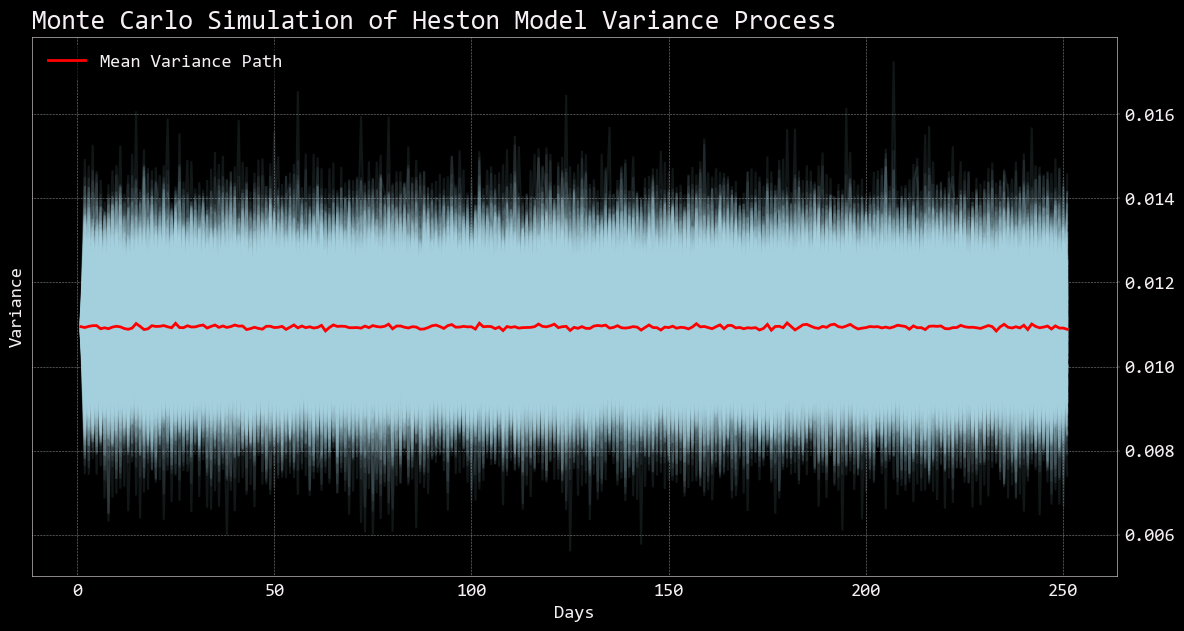

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot each simulated path
for path in mc_results:
    plt.plot(path, color='lightblue', alpha=0.1)

# Plot the mean path
plt.plot(mc_results.mean(axis=0), color='red', linewidth=2, label='Mean Variance Path')

plt.title('Monte Carlo Simulation of Heston Model Variance Process')
plt.xlabel('Days')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)
plt.show()
